Sam Odle <br>
December 2021  <br>
Project 3  <br>

# Part 0: Setup

In [2]:
import os, shutil, random
import torch, torchvision
import pandas as pd
import torch.utils.data as data
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from timeit import default_timer as timer

pd.set_option("display.max_rows", None)

In [3]:
# Whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = torch.cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

CUDA_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(CUDA_DEVICE)
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__CUDA Device Name:',torch.cuda.get_device_name(0))
print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

Train on gpu: True
1 gpus detected.
cuda
__CUDNN VERSION: 8200
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 2080 Ti
__CUDA Device Total Memory [GB]: 11.810832384


In [4]:
train_transforms = transforms.Compose([
    transforms.Resize(size=[224,224]),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # Imagenet standards
])

test_transforms = transforms.Compose([
        transforms.Resize(size=[224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])

valid_transforms = transforms.Compose([
        transforms.Resize(size=[224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])

In [5]:
BATCH_SIZE = 4
WORKERS = 4
DROP = False

TRAIN_DATA_PATH = "./images/train/"
TEST_DATA_PATH = "./images/test/"
HOLDOUT_DATA_PATH = "./images/holdout/"

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=train_transforms)
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=WORKERS, drop_last=DROP)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=test_transforms)
test_data_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, drop_last=DROP)

holdout_data = torchvision.datasets.ImageFolder(root=HOLDOUT_DATA_PATH, transform=test_transforms)
holdout_data_loader  = data.DataLoader(holdout_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, drop_last=DROP)


['great_dane', 'norfolk_terrier', 'norwich_terrier']


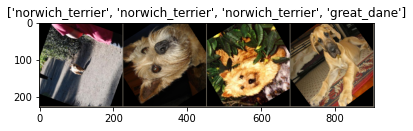

In [6]:
class_names = train_data.classes
print(class_names)

#source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_data_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
model = torchvision.models.vgg19(pretrained=True)

In [8]:
n_classes = 3

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False
n_inputs = model.classifier[6].in_features

# Add on classifier
# modified from: https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce
model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),
                      nn.LogSoftmax(dim=1))

print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=3, bias=True)
    (4): LogSoftmax(dim=1)
  )
)


In [9]:
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=.001)

In [10]:
# Move to gpu and parallelize
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

In [11]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [12]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_data_loader,
    test_data_loader,
    save_file_name='dog_id_model',
    max_epochs_stop=20,
    n_epochs=45,
    print_every=2)

Starting Training from Scratch.

poch: 1	5.33% complete. 1.37 seconds elapsed in epoch.Epoch: 1	14.67% complete. 1.59 seconds elapsed in epoch.Epoch: 1	28.00% complete. 1.79 seconds elapsed in epoch.Epoch: 1	42.67% complete. 2.00 seconds elapsed in epoch.Epoch: 1	57.33% complete. 2.20 seconds elapsed in epoch.Epoch: 1	72.00% complete. 2.41 seconds elapsed in epoch.Epoch: 1	86.67% complete. 2.61 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.5692 	Validation Loss: 0.4177
		Training Accuracy: 72.67%	 Validation Accuracy: 78.67%
poch: 3	5.33% complete. 1.33 seconds elapsed in epoch.Epoch: 3	20.00% complete. 1.54 seconds elapsed in epoch.Epoch: 3	34.67% complete. 1.74 seconds elapsed in epoch.Epoch: 3	49.33% complete. 1.95 seconds elapsed in epoch.Epoch: 3	64.00% complete. 2.16 seconds elapsed in epoch.Epoch: 3	78.67% complete. 2.36 seconds elapsed in epoch.Epoch: 3	93.33% complete. 2.57 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.4570 	Validation Loss: 0.2335
		Training Acc

Text(0.5, 1.0, 'Training and Validation Losses')

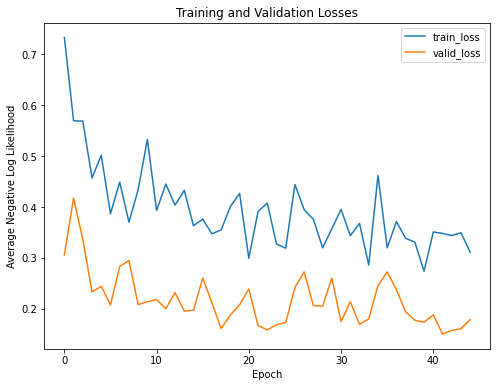

In [13]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

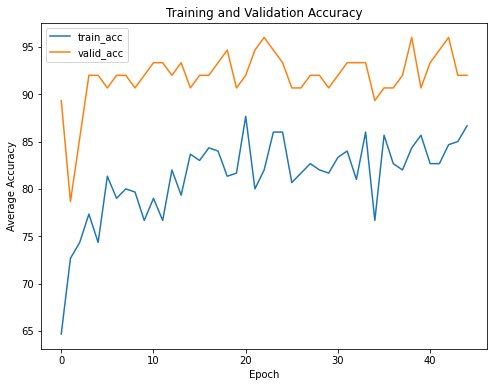

In [14]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')


In [15]:
holdout_loss = 0.0
holdout_acc = 0

with torch.no_grad():
    # Set to evaluation mode
    model.eval()

    # Validation loop
    for data, target in holdout_data_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Forward pass
        output = model(data)

        # Validation loss
        loss = criterion(output, target)
        # Multiply average loss times the number of examples in batch
        holdout_loss += loss.item() * data.size(0)

        # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        holdout_acc += accuracy.item() * data.size(0)

    # Calculate average losses
    holdout_loss = holdout_loss / len(holdout_data_loader.dataset)

    # Calculate average accuracy
    holdout_acc = holdout_acc / len(holdout_data_loader.dataset)
    holdout_acc = round(holdout_acc*100, 2)

print(f'Holdout Accuracy: {holdout_acc}%')


Holdout Accuracy: 89.86%


# Part 1: Generating Test Cases
In this section, we're going to design some datasets to convince ourselves that our model is giving us reasonable results. First, we'll generate some toy datasets from the Stanford dogs dataset where we know what the correct outcome should be. Complete the items below:

###### Generate a dataset of just three images, one for each class, and show your model correctly labels them. (display each image in your notebook, pass it to your model, and then print the prediction).	5 points

In [ ]:
P1A_DATA_PATH = "./images/P1_A_ThreeImageDataset/"
p1a_data = torchvision.datasets.ImageFolder(root=P1A_DATA_PATH, transform=test_transforms)
p1a_data_loader  = torch.utils.data.DataLoader(p1a_data, batch_size=3, shuffle=True, num_workers=WORKERS, drop_last=False)

#IMAGE 1
tensor_image, label = next(iter(p1a_data_loader))
if train_on_gpu:
    tensor_image, label = tensor_image.cuda(), label.cuda()

#print("Target label of image: ", label[0])
first_image = np.transpose(tensor_image[0].cpu().detach().numpy(), (1, 2, 0)) # get the first image in the batch
plt.imshow(first_image)
plt.show()

with torch.no_grad():
    # Set to evaluation mode
    model.eval()
    prediction = model(tensor_image)

print(prediction)
prediction = prediction.cpu().detach().numpy()
max_prob = max(list(np.array(prediction)[0]))
print('max_prob', max_prob)
predicted_label = list(prediction[0]).index(max_prob)
print("Predicted label: ", predicted_label)

tgt_lbl = label[0].item()
print("Target label: ", tgt_lbl)

if tgt_lbl == predicted_label:
    print("Successful prediction!")
else:
    print("Not quite...")

# IMAGE 2
tensor_image2, label2 = next(iter(p1a_data_loader))
if train_on_gpu:
    tensor_image2, label2 = tensor_image2.cuda(), label2.cuda()

second_image = np.transpose(tensor_image2[0].cpu().detach().numpy(), (1, 2, 0)) # get the first image in the batch
plt.imshow(second_image)
plt.show()

with torch.no_grad():
    # Set to evaluation mode
    model.eval()
    prediction2 = model(tensor_image2)

print(prediction2)
prediction2 = prediction2.cpu().detach().numpy()
max_prob = max(list(np.array(prediction2)[0]))
print('max_prob', max_prob)
predicted_label = list(prediction2[0]).index(max_prob)
print("Predicted label: ", predicted_label)

tgt_lbl = label[0].item()
print("Target label: ", tgt_lbl)

if tgt_lbl == predicted_label:
    print("Successful prediction!")
else:
    print("Not quite...")

# IMAGE 3
tensor_image3, label3 = next(iter(p1a_data_loader))
if train_on_gpu:
    tensor_image3, label3 = tensor_image3.cuda(), label3.cuda()

third_image = np.transpose(tensor_image3[0].cpu().detach().numpy(), (1, 2, 0)) # get the first image in the batch
plt.imshow(third_image)
plt.show()

with torch.no_grad():
    # Set to evaluation mode
    model.eval()
    prediction3 = model(tensor_image3)

print(prediction3)
prediction3 = prediction3.cpu().detach().numpy()
max_prob = max(list(np.array(prediction3)[0]))
print('max_prob', max_prob)
predicted_label3 = list(prediction3[0]).index(max_prob)
print("Predicted label: ", predicted_label3)

tgt_lbl = label[0].item()
print("Target label: ", tgt_lbl)

if tgt_lbl == predicted_label3:
    print("Successful prediction!")
else:
    print("Not quite...")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


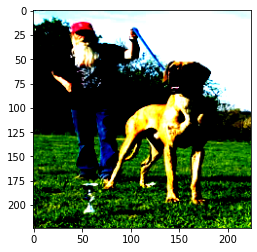

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pred / Tgt: 0 / 0


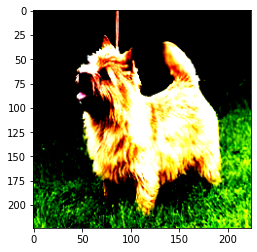

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pred / Tgt: 2 / 1


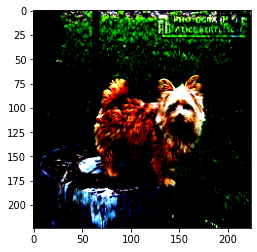

Pred / Tgt: 2 / 2


In [34]:
P1A_DATA_PATH = "./images/P1_A_ThreeImageDataset/"
p1a_data = torchvision.datasets.ImageFolder(root=P1A_DATA_PATH, transform=test_transforms)
p1a_data_loader  = torch.utils.data.DataLoader(p1a_data, batch_size=3, shuffle=True, num_workers=WORKERS, drop_last=False)

#IMAGE 1
tensor_image, label = next(iter(p1a_data_loader))
if train_on_gpu:
    tensor_image, label = tensor_image.cuda(), label.cuda()

with torch.no_grad():
    # Set to evaluation mode
    model.eval()
    prediction = model(tensor_image)

prediction = prediction.cpu().detach().numpy()

first_image = np.transpose(tensor_image[0].cpu().detach().numpy(), (1, 2, 0)) # get the first image in the batch
second_image = np.transpose(tensor_image[1].cpu().detach().numpy(), (1, 2, 0))
third_image = np.transpose(tensor_image[2].cpu().detach().numpy(), (1, 2, 0))

max_prob1 = max(list(np.array(prediction)[0]))
max_prob2 = max(list(np.array(prediction)[1]))
max_prob3 = max(list(np.array(prediction)[2]))

predicted_label1 = list(prediction[0]).index(max_prob1)
predicted_label2 = list(prediction[1]).index(max_prob2)
predicted_label3 = list(prediction[2]).index(max_prob3)

tgt_lbl1 = label[0].item()
tgt_lbl2 = label[1].item()
tgt_lbl3 = label[2].item()

plt.imshow(first_image)
plt.show()
print(f'Pred / Tgt: {predicted_label1} / {tgt_lbl1}')

plt.imshow(second_image)
plt.show()
print(f'Pred / Tgt: {predicted_label2} / {tgt_lbl2}')

plt.imshow(third_image)
plt.show()
print(f'Pred / Tgt: {predicted_label3} / {tgt_lbl3}')

###### Generate three datasets of our inputs, where each has only two of the classes. What do you predict the performance should be for three binary classifiers trained on these three datasets? Re-train your model on these three datasets, and discuss your results.	5 points

###### Generate a dataset from your original dataset where 20% of the classes in one class are mis-labelled as the remaining two classes. How do you think your model performance will be impacted? Re-train your model on this test dataset, and discuss your results.

# Part 2: Biases in the modeling

###### Take a look at each of the images in all classes individually. What aspects of the image (such as backgrounds) might be influencing the decision-making of the model, besides the dogs themselves?	5 points

###### Calculate the "average image" across all pixels of each of your classes in your training dataset. Are your results consistent with the previous item?	5 points

###### Is the data biased in any way that could impact your results? Why or why not?
###### If you noted some potential biases in the modeling/dataset above, discuss how you could help mitigate these biases (you don't need to implement, just discuss). If you didn't note any biases in this dataset, discuss what biases there could have been, and how the dataset designers might have helped mitigate them.

# Part 3: Model uncertainty and explainability
We discussed earlier this semester how deep learning models can be black boxes; it's hard to tell what the models really learned, that is, what are the using to make their decisions?

Overall, we got incredibly good performance earlier with just a couple hundred images per class. Let's investigate how much pre-training with ImageNet helped us achieve those results. First, re-train your model, but this time don't use a pre-trained version (you can set the flag to False). What happened? Include a discussion in your notebook.

Next, let's see what happens in two cases:
When we try to build a model on just the head of the dog (cropping just the head/face)
When we crop the dog out of the image, leaving just the background
Discuss two hypotheses for the two datasets above -- how do you think they should perform, and why. If you have time, you can manually build the two datasets above and re-train your model, but you're not required to.

Pixel importance with saliency maps
Finally, let's see how much each pixel contributes to the final decision of the model using saliency mapping. Although saliency mapping has its limitations and is not the be-all-end-all of this type of analysis, it will at least get us started this semester towards a discussion of model explainability.

Write a loop that goes through every image in your dataset and prints out the original image and a saliency map for each image. Use any resources you find online (other than asking someone to do the work for you!) to generate such a saliency map; you can probably do this in about 20 lines of code without the need to import any more libraries, but feel free to get fancy! If you get stuck, as us for help on Ed. Make sure you cite any resources you used!

Finally, include a discussion of the output of your saliency analysis for this dataset -- what do you think this means in terms of your model performance?


###### Discussion of how model should behave if trained just on heads of dogs

###### Discussion of how model should behave if trained just on backgrounds without dogs

###### Discussion of model performance without using pre-trained weights vs using pre-trained weights.

###### Correctly implementing saliency maps for all images.	5 points

###### Discussion of saliency mapping results.


# Extra Credit

##### Evaluating Saliency Map Explanations for Convolutional Neural Networks: A User Study


##### Testing and validating machine learning classifiers by metamorphic testing